# Predicting location of Spike protein in SARS-CoV2 DNA  

Some fooling around trying to predict the spike protein location inside SARS-CoV2 DNA. Raw DNA will be transformed into Entropy values via [dnasr](https://github.com/Luk13Mad/dnasr), annotated with the spike protein location and then piped into a TF model.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
print("all packages loaded")

all packages loaded


# Preparing sequences  
If you want to skip the data polishing and annotating jump straight to "Prepare data for TF" EDIT:File was to large for upload. 

In [16]:
fasta_file=os.path.join(os.getcwd(),"data","sequences.fasta") #file with DNA sequences
myrecords=[seq_record for seq_record in SeqIO.parse(fasta_file, "fasta")]
myrecords=list(filter(lambda x: 26000 < len(x) < 32000, myrecords)) #filter for full genomes
print(f"Number of SARS-Cov2 sequences in file: {len(myrecords)}")
SPIKE_PROTEIN=[seq_record for seq_record in SeqIO.parse(os.path.join(os.getcwd(),"data","spike_protein.fasta"), "fasta")][0]
#File with spike protein which will be our target we try to predict
print(f"Length of DNA coding for spike protein: {len(SPIKE_PROTEIN)}")

Number of SARS-Cov2 sequences in file: 2280
Length of DNA coding for spike protein: 3822


In [17]:
myrecords=list(filter(lambda x: x.seq.find(SPIKE_PROTEIN.seq)!= -1,myrecords)) 
#filter for records containing the spike protein with no mismatches
print(f"Number of SARS-Cov2 sequences containing spike protein with no mismatches: {len(myrecords)}")

Number of SARS-Cov2 sequences containing spike protein with no mismatches: 160


In [18]:
for rec in myrecords: #add SeqFeature with SPIKE_PROTEIN location to each record, we will try to predict the position fo the spike protein from the entropy values
    start=rec.seq.find(SPIKE_PROTEIN.seq)
    end=start+len(SPIKE_PROTEIN)
    rec.features.append(SeqFeature(location=FeatureLocation(start=start,end=end),type="SPIKE_PROTEIN"))

In [13]:
SeqIO.write(random.sample(myrecords,50),os.path.join(os.getcwd(),"data","processed_seq.fasta"), "fasta")
#write 50 records to file
#only 50 so i can still load output from dnasr into RAM

50

# Calling DNASR 

Now call dnasr. Instructions how to install here https://github.com/Luk13Mad/dnasr .
Switch cell below to "CODE" and run it see how command looks like.

inp=os.path.join(os.getcwd(),"data","processed_seq.fasta")  
outp=os.path.join(os.getcwd(),"data")  
print(f"dnasr generate --db false -i {inp}  -o {outp} --ee true")  

# Loading and annotating entropy data

In [2]:
mydf=pd.read_csv(os.path.join(os.getcwd(),"data","dnasr_early_exit.txt"),sep="\t",header=None,names=["ID","window","kmer","E"])
#load output form dnasr

In [7]:
mydf.sort_values(by=["ID","window","kmer"],inplace=True)
mydf.reset_index(drop=True,inplace=True)
mydf.loc[mydf.E.isna(),"E"]=0

In [11]:
mydf["isSpike"]=0 #add column indicating whether position is inside spike
mydf.head()

,ID,window,kmer,E,isSpike
94838586,MW375727.1,29655,TGT,0.901785,0
94838587,MW375727.1,29655,TTA,0.997746,0
94838588,MW375727.1,29655,TTC,1.000000,0
94838589,MW375727.1,29655,TTG,1.000000,0
94838590,MW375727.1,29655,TTT,0.000000,0


In [16]:
for rec in myrecords:
    if mydf.ID.isin([str(rec.id)]).any():
        mask1=mydf.loc[:,"window"].isin(range(int(rec.features[0].location.start),int(rec.features[0].location.end)))
        mask2=mydf["ID"]==rec.id
        mydf.loc[pd.concat([mask1,mask2],axis=1).all(axis=1),"isSpike"]=1 #change "isSpike" column to 1 if spike present

print("done")

done


In [17]:
#mydf.to_csv(os.path.join(os.getcwd(),"data","finished_data.csv.gz"),sep="\t",compression="gzip",index=False)

# Prepare data for TF

In [39]:
mydf=pd.read_csv(os.path.join(os.getcwd(),"data","finished_data.csv.gz"),sep="\t",compression="gzip")

In [41]:
shapes=[] #get max length for later padding
for ID,inner_df in mydf.groupby(by=["ID"]):
    shapes.append(inner_df.shape)

In [55]:
max_len=max([x[0] for x in shapes])

def make_dict2(): #make dict to feed into Dataset.from_tensor_slices
    mydict={"ID":[],"E":[],"isSpike":[]}
    for ID,inner_df in mydf.groupby(by=["ID"]):
        mydict["ID"].append(ID)
        #padding with 0
        mydict["E"].append( np.pad(np.array(inner_df.E),(0,max_len-inner_df.shape[0]), 'constant', constant_values=0).reshape((-1,64)) )
        mydict["isSpike"].append( np.array(inner_df.groupby("window").mean().isSpike) ) #each window gets 1 spike value
    _max_window=max([len(x) for x in mydict["isSpike"]])
    for idx,i in enumerate(mydict["isSpike"]):
        len_before=len(i)
        mydict["isSpike"][idx]=np.pad(i,(0,_max_window-len_before), 'constant', constant_values=0)
    return mydict,_max_window
mydict2,max_window=make_dict2()

In [56]:
tf_dataset2=tf.data.Dataset.from_tensor_slices(mydict2)

In [57]:
train_size2 = int(0.8 * tf_dataset2.cardinality().numpy()) #split dataset into train and test
test_size2 = int(0.2 * tf_dataset2.cardinality().numpy())

tf_dataset2 = tf_dataset2.shuffle(tf_dataset2.cardinality().numpy()*1,1)
train_dataset2 = tf_dataset2.take(train_size2)
test_dataset2 = tf_dataset2.skip(train_size2)

In [5]:
max_len=max([x[0] for x in shapes])

def make_dict1(): #make dict to feed into Dataset.from_tensor_slices
    mydict={"ID":[],"E":[],"isSpike":[]}
    for ID,inner_df in mydf.groupby(by=["ID"]):
        for w,x in inner_df.groupby("window"):
            mydict["ID"].append(ID)
            mydict["E"].append( np.pad(np.array(x.E),(0,64-len(np.array(x.E))), 'constant', constant_values=(0,0)))
            mydict["isSpike"].append( np.mean(np.array(x.isSpike)) ) #each window gets 1 spike value
    return mydict
mydict1=make_dict1()

In [6]:
tf_dataset1=tf.data.Dataset.from_tensor_slices(mydict1)

In [7]:
train_size1 = int(0.8 * tf_dataset1.cardinality().numpy()) #split dataset into train and test
test_size1 = int(0.2 * tf_dataset1.cardinality().numpy())

tf_dataset1 = tf_dataset1.shuffle(tf_dataset1.cardinality().numpy()*1,1)
train_dataset1 = tf_dataset1.take(train_size1)
test_dataset1 = tf_dataset1.skip(train_size1)

# Set up Model 1 

In [50]:
train_labels1=train_dataset1.map(lambda d : d["ID"])
train_feature1=train_dataset1.map(lambda d : d["E"])
train_target1=train_dataset1.map(lambda d : d["isSpike"])

test_labels1=test_dataset1.map(lambda d : d["ID"])
test_feature1=test_dataset1.map(lambda d : d["E"])
test_target1=test_dataset1.map(lambda d : d["isSpike"])

In [9]:
inputs=keras.Input(shape=(64,))
x=layers.Dense(64, activation="relu")(inputs)
x=layers.Dropout(0.2)(x)
x=layers.Dense(64, activation="relu")(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="spike_predictor")
model.summary()

Model: "spike_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________

In [10]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = model.fit(tf.data.Dataset.zip((train_feature1,train_target1)).batch(100),epochs=3)


Epoch 1/3
11855/11855 [==============================] - 38s 3ms/step - loss: 0.3900 - accuracy: 0.8707
Epoch 2/3
11855/11855 [==============================] - 30s 2ms/step - loss: 0.3838 - accuracy: 0.8717
Epoch 3/3
11855/11855 [==============================] - 31s 2ms/step - loss: 0.3844 - accuracy: 0.8712


In [11]:
test_score=model.evaluate(tf.data.Dataset.zip((test_feature1,test_target1)).batch(100))
print(test_score)

2964/2964 [==============================] - 18s 2ms/step - loss: 0.3837 - accuracy: 0.8714
[0.38368842005729675, 0.8714212775230408]


In [12]:
mydf=pd.DataFrame(mydict1)

In [14]:
mypredictions={}
for _id,sub in mydf.groupby("ID"):
    mypredictions.update({_id:[]})
    if len(mypredictions.keys())==2:break
    for arr in sub.E:
        mypredictions[_id].append( model.predict(tf.expand_dims(arr, axis=0)).flatten() )


Text(0.5, 1.0, 'LR877726.1')

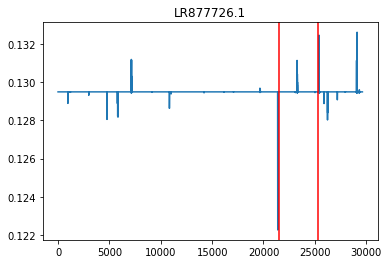

In [26]:
#predictions=np.load(os.path.join(os.getcwd(),"data","predictions.npy"))
average_start=np.mean([int(rec.features[0].location.start) for rec in myrecords])
average_end=np.mean([int(rec.features[0].location.end) for rec in myrecords])
plt.plot(np.arange(len(np.array(mypredictions["LR877726.1"]).flatten())),np.array(mypredictions["LR877726.1"]).flatten())
plt.axvline(average_start,color="red")
plt.axvline(average_end,color="red")
plt.title("LR877726.1")

Plot for predictions for LR877726.1. Windows were fed into the model and the predictions were rearranged in the correct order and plotted. As we can see from the calculations below the accuracy of the model is simply a reflection of the percentage of zero labels. ==> The model is useless.

In [36]:
unique, counts = np.unique(np.array(mydf.loc[mydf.ID=="LR877726.1",:].isSpike), return_counts=True)
length=len(np.array(mydf.loc[mydf.ID=="LR877726.1",:].isSpike))

print(f"Percentage of zero labels in LR877726.1 : {counts[0]/length}")
print(f"Percantage of one labels in LR877726.1 : {counts[1]/length}")

Percentage of zero labels in LR877726.1 : 0.8710047588511256
Percantage of one labels in LR877726.1 : 0.12899524114887442


# Set up Model 2

In [58]:
train_labels2=train_dataset2.map(lambda d : d["ID"])
train_feature2=train_dataset2.map(lambda d : d["E"])
train_target2=train_dataset2.map(lambda d : d["isSpike"])

test_labels2=test_dataset2.map(lambda d : d["ID"])
test_feature2=test_dataset2.map(lambda d : d["E"])
test_target2=test_dataset2.map(lambda d : d["isSpike"])

In [52]:
inputs=keras.Input(shape=(int(max_len/64),64))
x=layers.Flatten()(inputs)
x=layers.Dense(64, activation="relu")(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(max_window,activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="spike_predictor")
model.summary()


Model: "spike_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29753, 64)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1904192)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                121868352 
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 29753)             1933945   
Total params: 123,802,297
Trainable params: 123,802,297
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = model.fit(tf.data.Dataset.zip((train_feature2,train_target2)).batch(10),epochs=3)

Epoch 1/3
4/4 [==============================] - 8s 903ms/step - loss: 3.0187 - accuracy: 0.0000e+00
Epoch 2/3
4/4 [==============================] - 4s 655ms/step - loss: 0.6913 - accuracy: 0.0000e+00
Epoch 3/3
4/4 [==============================] - 3s 615ms/step - loss: 0.6896 - accuracy: 0.0000e+00


In [61]:
test_score=model.evaluate(tf.data.Dataset.zip((test_feature2,test_target2)).batch(5))
print(test_score)

2/2 [==============================] - 3s 127ms/step - loss: 0.6882 - accuracy: 0.0000e+00
[0.6881964802742004, 0.0]


In [62]:
predictions=model.predict(test_feature2.batch(1))

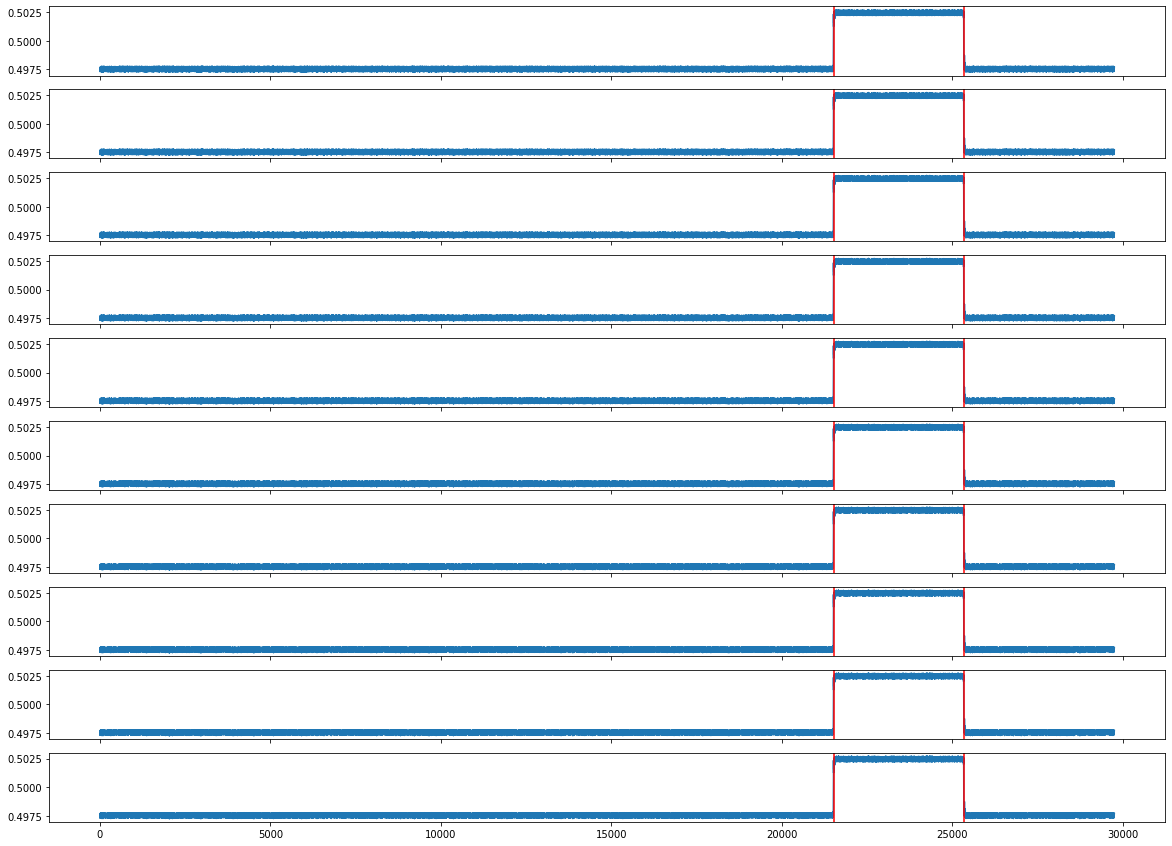

In [63]:
average_start=np.mean([int(rec.features[0].location.start) for rec in myrecords])
average_end=np.mean([int(rec.features[0].location.end) for rec in myrecords])
fig, axs = plt.subplots(10,sharex=True,figsize=(20,15))
for i in range(10):
    axs[i].plot(np.arange(len(predictions[i])),predictions[i])
    axs[i].axvline(average_start,color="red")
    axs[i].axvline(average_end,color="red")

Looks good but perhaps the model is predicting solely on position. Let's try and feed it an artificial input with no meaningfull numbers.

In [71]:
only_zero=np.zeros(29753*64).reshape((29753, 64))
only_ones=np.ones(29753*64).reshape((29753, 64))

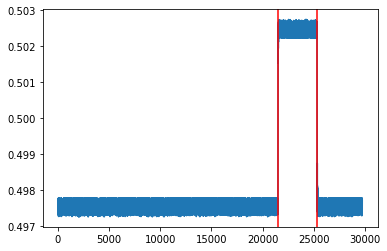

In [78]:
fake_pred_1=model.predict(tf.expand_dims(tf.constant(only_zero), axis=0)).flatten()
plt.plot(np.arange(len(fake_pred_1)),fake_pred_1)
plt.axvline(average_start,color="red")
plt.axvline(average_end,color="red")

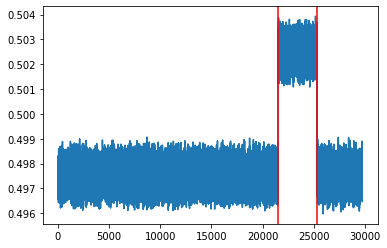

In [79]:
fake_pred_2=model.predict(tf.expand_dims(tf.constant(only_ones), axis=0)).flatten()
plt.plot(np.arange(len(fake_pred_2)),fake_pred_2)
plt.axvline(average_start,color="red")
plt.axvline(average_end,color="red")

Apart from some noise it seems the model is in fact predicting based on position alone and not based on the entropy values.

# Set up Model 3  
Maybe a combination of Model 1 and Model 2 will lead to better results.